# Amazon Reviews Analysis
1. Author       : Naman Garg
2. Date Created : May 3, 2025

## Introduction
We have an artificially balanced Multilingual Amazon Review Dataset. This is a naive and surface exploration of the data for the purposes of presentation of Data Science skills and academics. This project is a shallow dive into the review data to explore and understand the nuances before prototyping:   
1. Multilingual sentiment classification system to predict star ratings
2. Product recommender based on reviewer behaviour and experience 
3. Spam review detection system.  

### Dataset
number of samples in training data: 1.2 million
number of samples in validation data: 30,000

**Data Fields**  

*review_id*: A string identifier of the review.  
*product_id*: A string identifier of the product being reviewed.  
*reviewer_id*: A string identifier of the reviewer.  
*stars*: An int between 1-5 indicating the number of stars.  
*review_body*: The text body of the review.  
*review_title*: The text title of the review.  
*language*: The string identifier of the review language.  
*product_category*: String representation of the product's category.  

**Data set is artificially balanced:**

Number of samples for each star rating (1-5): 240,000  
Number of samples for language (en/es/da/fr/ja/zh): 200,000  
Number of samples for language (en/es/da/fr/ja/zh) for each star rating (1-5): 40,000  

### Problem Statements
**PS-1:** Given this balanced dataset of product reviews, how would you build a sentiment analysis model to predict star ratings? What potential biases should you consider given that the dataset was artificially balanced?  
**PS-2:** How would you leverage both review_body and review_title fields to improve classification accuracy? What architectures would you consider for combining these text features?  
**PS-3:** If you needed to build a multilingual review classification system using this dataset, what approach would you take considering the language field? What challenges might you face?  
**PS-4:** How would you design a recommendation system using the product_id, reviewer_id, and stars fields? What additional features could you engineer from the text fields to improve recommendations?  
**PS-5:** If you needed to detect fake or spam reviews in this dataset, what features and approaches would you use? How would you handle the challenge of limited labeled data for fake reviews?  

### Libraries
contractions==0.1.73  
ipykernel==6.29.5  
Jinja2==3.1.6  
matplotlib==3.10.1  
notebook==7.4.1  
nltk==3.9.1  
numpy==2.2.5  
pandas==2.2.3  
python==3.12.4  
regex==2024.11.6  
scikit-learn==1.6.1  
scipy==1.15.2  
seaborn==0.13.2  
textblob==0.19.0  
torch==2.7.0  
xgboost==3.0.0  

### Out of Scope
Deep Analysis of language nuances.  
Using transformer based model and architecture for sentiment analysis.  
Hyperparameter tuning.  
References

## Foundational Exploratory Data Analysis (EDA)
**Objective:**  
Understand dataset structure, detect imbalances, and uncover preliminary insights from text and metadata.

### Dataset Structure Examination
**Objective:**  
1. Check shape, missing values, and data types
2. Verify balanced nature of star ratings
3. Examine language distribution
    - How many languages are present in the dataset  
    - If there is class imbalance among the languages in the dataset  

#### Initial Setup and Data Loading


In [1]:
#essential libraries for EDA
import pandas as pd #pandas for data manipulation and analysis
import numpy as np  #numpy for numerical computations
import matplotlib.pyplot as plt #for creating visualizations
import seaborn as sns #for quick statistical data visualizations and aesthetics

# Visualization defaults
sns.set_theme(style="whitegrid") # Clean visual style
pd.set_option('display.max_colwidth', 200)  # Show full text in DataFrame displays

#for reproducibility
random_state = 12

In [2]:
from pathlib import Path #for path handling and cross platform compatibility


# dataset paths for cross-platform compatibility
train_path = Path ("data/train.csv")
val_path = Path ("data/validation.csv")

# Checking if files exist
assert train_path.exists(), f"Training data not found at {train_path}"
assert val_path.exists(), f"Validation data not found at {val_path}"

# Loading data
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

print("Data loaded successfully!")

#Checking memory usage for both Training and Validation Datasets
print(f"\nTraining Dataset memory usage: {train_df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
print(f"Validation Dataset memory usage: {val_df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")

#Checking sample size of both Training and Validation Datasets
print(f"\nSample size of Training dataset: {train_df.shape[0]}")
print(f"Sample size of Validation dataset: {val_df.shape[0]}")

#Checking Training set to Validation set split-ratio
print(f"\nTraining set to Validation set split-ratio: ~{int(train_df.shape[0]/val_df.shape[0])}/1") 

Data loaded successfully!

Training Dataset memory usage: 729.85 MB
Validation Dataset memory usage: 18.18 MB

Sample size of Training dataset: 1200000
Sample size of Validation dataset: 30000

Training set to Validation set split-ratio: ~40/1


**Observations and takeaways:**  
1. Training Dataset is taking up 729.85 MB of memory, optimization opportunities based on Dataset description  
    - Converting 'stars' from Int64 to Int8; need to verify maximum and minimum value of star rating  
    - Converting 'language' from Object to Category; need to check unique values  
    - Converting 'product_category' from Object to Category; need to check unique values  
2. Training set to Validation split ratio is 40:1  
    - Even though only 2.5% of the data is allocated to validation set, with 30,000 samples it might still be statistically meaningful  
    - Dataset is artificially balanced, which might have led to some rare product categories and rare languages to be under-represented.   
    - This might be further exacebrated in validation set due to it being comparatively quiet small to training set.  
    - Might need to use stratified sampling for product categories and langugages if they are found to be relatively under-represented. 
3. Data loaded in ~8.4 seconds; reasonable load time.  

#### Data Structure Validation
**Objective:**  
1. Confirm the dataset matches expected schema
2. Verify that all columns mentioned in Dataset description are present
3. Verify data types for all columns mentioned in the dataset is as expected
4. Verify Primary Key ('review_id') is unqiue across training and validation dataset
5. Verify there is no data leakage between training and validation dataset
6. Verify stars are numeric and selected only from the set of {1,2,3,4,5}
7. Inspect Dataset samples


In [3]:

def validate_dataset_structure(df: pd.DataFrame, dataset_name: str) -> None:
    """Structure validator

    Validates dataset integrity:
    1. Presence of all expected columns
    2. Uniqueness of primary key (review_id)
    3. Correct dtypes for specified columns

    Args:
        df: DataFrame to validate
        dataset_name: Human-interpretable name for error messages (e.g., "Training Set")
        
    Raises:
        AssertionError: If any validation fails
    """
    
    print(f"\nValidating {dataset_name} structure...")
    
    # 1. Validate Column existence
    # Ensures no columns are missing compared to predefined `expected_columns`
    missing_cols = expected_columns - set(df.columns)
    assert not missing_cols, f"{dataset_name} missing columns: {missing_cols}"

    # 2. Primary key check
    # Checks for duplicate review_ids (should be 0 for a clean dataset)
    dup_ids = df['review_id'].duplicated().sum()
    print(f"Duplicate review_ids: {dup_ids}") # logging instead of assert for visibility
    
    # 3. Validate data types
    # Verifies critical columns have correct dtypes (e.g., 'stars' is int, not float)
    for col, expected_type in dtype_checks.items():
        assert df[col].dtype == expected_type, \
            f"{dataset_name} {col} dtype mismatch"
    
#List of all critical columns expected to be in the Dataset
expected_columns = {
    'review_id', 'product_id', 'reviewer_id', 
    'stars', 'review_body', 'review_title',
    'language', 'product_category'
}

# Dictionary of all Columns associated with their expected datatype
dtype_checks = {
    'review_id': 'object',
    'product_id': 'object',
    'reviewer_id': 'object',
    'stars': 'int64',
    'review_body': 'object',
    'review_title': 'object',
    'language': 'object',
    'product_category': 'object'
}

# Validate both datasets
validate_dataset_structure(train_df, "Training Set")
validate_dataset_structure(val_df, "Validation Set")


Validating Training Set structure...
Duplicate review_ids: 0

Validating Validation Set structure...
Duplicate review_ids: 0


In [4]:
'''
Checks if any review ID is present in both Training dataset and Validation dataset to ensure there is no data leakage
Silent execution -> validation passed
Raises Assertion error if data leakage identified
'''

print("\nChecking for data leakage (shared review_ids)...")
shared_ids = set(train_df['review_id']).intersection(set(val_df['review_id']))
assert not shared_ids, f"Data leakage: {len(shared_ids)} shared review_ids"


'''
Stars rating range check
prints all unique values present in 'stars'
checking manually since expected range of values is small
'''
print("\nStars value validation:")
print("Allowed values:", [1, 2, 3, 4, 5])
print("Actual unique values:", sorted(train_df['stars'].unique().tolist()))


Checking for data leakage (shared review_ids)...

Stars value validation:
Allowed values: [1, 2, 3, 4, 5]
Actual unique values: [1, 2, 3, 4, 5]


In [5]:
# Sample inspection
print("\nTraining sample:")
display(train_df.head(2).T)  # Transposed for readability

print("\nValidation sample:")
display(val_df.head(2).T)  # Transposed for readability


Training sample:


,0,1
Unnamed: 0,0,1
review_id,de_0203609,de_0559494
product_id,product_de_0865382,product_de_0678997
reviewer_id,reviewer_de_0267719,reviewer_de_0783625
stars,1,1
review_body,Armband ist leider nach 1 Jahr kaputt gegangen,In der Lieferung war nur Ein Akku!
review_title,Leider nach 1 Jahr kaputt,EINS statt ZWEI Akkus!!!
language,de,de
product_category,sports,home_improvement



Validation sample:


,0,1
Unnamed: 0,0,1
review_id,de_0591095,de_0987834
product_id,product_de_0301773,product_de_0720578
reviewer_id,reviewer_de_0787123,reviewer_de_0983846
stars,1,1
review_body,"Das Produkt kam bis heute nicht bei mir an. Ich bin stocksauer! Trotz der langen Lieferzeit (sollte zwischen dem 1. und 10. März geliefert werde), ist das Produkt auch eine Woche nach dem späteste...","Gebrauchte Spinner, teilzerlegt und teilweise mit bereits oxidierten Fingerabdrücken (s. Foto) auf dem Metall. Ekelhaft."
review_title,Produkte NICHT geliefert,"Gebrauchtware, ekelhaft"
language,de,de
product_category,toy,toy


**Observations:**  
1. All expected columns are present in the Dataset
2. Data types for all columns mentioned in the dataset is as expected
4. Primary Key ('review_id') is unqiue across training and validation dataset
5. There is no data leakage between training and validation dataset
6. stars are numeric and selected only from the set of {1,2,3,4,5}
7. Sample inspection led to the discovery of unexpected column: 'Unnamed: 0' in both training and validation dataset  
    - This column was probably created when dataset was initially converted to csv with **index = True**  
    - Need to check if values are same as Dataframe index, and drop the column if check came positive  

In [6]:
#Verifying if 'Unnamed: 0' is redundant to drop it or investigate further
def unnamed_col_check(df: pd.DataFrame, dataset_name: str):
    if (df['Unnamed: 0'] == df.index).all():
        print(f"Column matched DataFrame index in {dataset_name} - Dropped")
        df = df.drop(columns=['Unnamed: 0'])
    else:
        print(f"Column doesn't match index in {dataset_name} - Further investigation needed")
        display(df['Unnamed: 0'].describe())
    return df

train_df = unnamed_col_check(train_df, "Training Set")
val_df = unnamed_col_check(val_df, "Validation Set")

Column matched DataFrame index in Training Set - Dropped
Column matched DataFrame index in Validation Set - Dropped


#### Checking and Handling missing values
**Objective:**
1. Check if there are missing values in columns  
    - Missing values will impact all downstream tasks  
    - Model training fails with NaN text  

In [7]:
#Checks for percentage of missing values in each column in training and validation set
def analyze_missing_values(df: pd.DataFrame, dataset_name: str) -> None:
    print(f"\nMissing Value Analysis: {dataset_name}")
    
    # 1. Quantitative summary
    missing = df.isna().sum()
    missing_pct = missing / len(df) * 100
    missing_report = pd.concat(
        [missing, missing_pct], 
        axis=1, 
        keys=['Total Missing', 'Percentage']
    ).sort_values('Percentage', ascending=False)
    
    display(missing_report[missing_report['Total Missing'] > 0])
    
    # 2. Critical field check
    for field in ['review_body', 'stars']:
        assert df[field].isna().sum() == 0, \
            f"Critical field '{field}' has missing values"

# Analyze both datasets
analyze_missing_values(train_df, "Training Set")
analyze_missing_values(val_df, "Validation Set")


Missing Value Analysis: Training Set


,Total Missing,Percentage
review_title,43,0.003583



Missing Value Analysis: Validation Set


,Total Missing,Percentage
review_title,2,0.006667


**Observation:**
1. Only a very small percantage of values are missing from review_title for both training and validation dataset
2. Rest of the Dataset is complete

**Actions:**
1. Possible course of actions and considerations to be taken while training the model:  
    - Filling in with a simple placeholder "[NO_TITL]"  
        - 'review_title' is a critical feature downstream models may treat it as a special pattern  
    - Filling in with a simple placeholder "[NO_TITL]" + first 20 characters of review body
        - 'review_title' is a critical feature downstream models may treat ["NO_TITL"] it as a special pattern
        - Added context from review body will increase uniqueness over a simple placeholder
    - Deleting the records with missing review title
        - It's simple
        - The percentage of records with missing values is very small
        - Missing data doesn't have a random pattern and occur only within review_title. 
        - Deleting may lead to rare and valueable patterns to be lost
    - Generating Review titles via LLMs based on review body
        - A huge overkill for a very small missing percentage
2. Making the decision to fill in with a simple placeholder "[NO_TITL]" + first 20 characters of review body
    - It preserves the artificial balance of the dataset
    - Review_title is a critical field and preserving it makes sense
    - While using transformer model on this, the model will be able to recodnize it as a special token
    - Will do it in model processing pipeline.  
        - If Title is present concatenate [TITL] before title body
        - If Title is missing fill in [NO_TITL] before first 20 characters of review body
    


#### Dataset Class balance verification
**Objective:**
1. Confirm that dataset is indeed artificially balanced on distribution on 'stars' values in both training and validation dataset
2. Check class distribution of 'languages' values
3. Check class distribution of 'product-categories' values

In [8]:
#Checking for star rating balance
star_balance = pd.concat([  
    train_df['stars'].value_counts(normalize=True).rename('train'),  
    val_df['stars'].value_counts(normalize=True).rename('val')  
], axis=1)  

star_balance['diff'] = (star_balance['train'] - star_balance['val']).abs()

display(star_balance)

,train,val,diff
stars,,,
1,0.2,0.2,0.0
2,0.2,0.2,0.0
3,0.2,0.2,0.0
4,0.2,0.2,0.0
5,0.2,0.2,0.0


In [9]:
#Checking for Language balance
language_balance = pd.concat([  
    train_df['language'].value_counts(normalize=True).rename('train'),  
    val_df['language'].value_counts(normalize=True).rename('val')  
], axis=1)  

language_balance['diff'] = (language_balance['train'] - language_balance['val']).abs()

print(f"Total number of Languages in the dataset: {pd.concat([train_df['language'], val_df['language']]).nunique()}")
display(language_balance)

Total number of Languages in the dataset: 6


,train,val,diff
language,,,
de,0.166667,0.166667,0.0
en,0.166667,0.166667,0.0
es,0.166667,0.166667,0.0
fr,0.166667,0.166667,0.0
ja,0.166667,0.166667,0.0
zh,0.166667,0.166667,0.0


In [10]:
#Checking for product category balance
product_cat_balance = pd.concat([  
    train_df['product_category'].value_counts(normalize=True).rename('train'),  
    val_df['product_category'].value_counts(normalize=True).rename('val')  
], axis=1)  

product_cat_balance['diff'] = (product_cat_balance['train'] - product_cat_balance['val']).abs()

print(f"Total number of Product categories in the dataset: {pd.concat([train_df['product_category'], val_df['product_category']]).nunique()}")
display(product_cat_balance)

Total number of Product categories in the dataset: 31


,train,val,diff
product_category,,,
home,0.105148,0.101133,0.004014
wireless,0.092115,0.089267,0.002848
book,0.075672,0.074533,0.001138
sports,0.054530,0.054867,0.000337
apparel,0.048006,0.047500,0.000506
toy,0.047459,0.047867,0.000408
pc,0.046311,0.047267,0.000956
home_improvement,0.044570,0.044967,0.000397
beauty,0.043912,0.044900,0.000988


**Observation:**
1. 'stars' values are perfectly and equally balanced across both Training and Validation datasets
2. 'language' values are perfectly and equally balanced across both Training and Validation datasets
3. Each product_category' value is almost equally represented in both Training and Validation datasets
4. There are only 6 language categories. It makes sense to convert its data type from object into category, to reduce memory usage
5. There are only 6 product categories. It makes sense to convert its data type from object into category, to reduce memory usage

#### Restructuring Data Types for Memory Optimization
**Objectives:**
1. Convert Data type of 'language' and 'product_category' from 'object' to 'category'
2. Downcast 'star' from int64 to int8

In [11]:
'''
Downcasts 'star' rating form int64 to int8
Converts 'language' from object to category
Converts 'product_category' from object to category
'''

def restructure_dataset(df: pd.DataFrame, dataset_name: str) -> None:
    
    # Downcast 'star' from int64 to int8
    df['stars'] = pd.to_numeric(df['stars'], downcast='integer')

    #converted Datatype from object to category in language and product category columns
    for col in ['language','product_category']:
        df[col] = df[col].astype('category')
    
    print(f"{dataset_name}'s has been successfully optimized for memory")
    return df

print("Before memory optimization")
print(f"\nTraining Dataset memory usage: {train_df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
print(f"Validation Dataset memory usage: {val_df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB\n")

train_df = restructure_dataset(train_df,"Training Set")
val_df = restructure_dataset(val_df,"Val Set")

print("\nAfter memory optimization")
print(f"\nTraining Dataset memory usage: {train_df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
print(f"Validation Dataset memory usage: {val_df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")


Before memory optimization

Training Dataset memory usage: 720.70 MB
Validation Dataset memory usage: 17.95 MB

Training Set's has been successfully optimized for memory
Val Set's has been successfully optimized for memory

After memory optimization

Training Dataset memory usage: 591.38 MB
Validation Dataset memory usage: 14.72 MB


**Observation:**
1. Training and Validation Datasets' memory usage decreased by 16% which is a significant decrease

#### Key Takeaways
1. Dataset is perfectly balanced across different 'stars' values
2. Dataset is perfectly balanced across different 'language' values
3. The Training to Validation split ratio is 40:1
4. Considerable large sample size of validation dataset still makes it statistically meaningful
5. A very small percentage of values that were missing from review_title have been synthetically filled in.
6. Dataset was very hygenic to from the start
7. Only minor changes were required to before moving onto Analysis

### Basic Text Analysis
**Major Objective:**
1. Review length analysis per star rating
    - Checking if review length has any correlation with star rating.
        - Motivation: Generally, 5 star reviews are often balanced, while 1 star reviews are rant like
    - Checking if review length has any correlation with Language, some reviews may be longer or shorter depending upon language syntax.
        - Motivation: German generally has more compound words, which leads to longer words but needs less number of words to express the information.
        - French and Spanish generally use more words to express same information. 
        -  (Chinese) and Japanese Language is generally shorter compared to English while carrying the same information, primarily due to complexity of their script.
2. Word frequency analysis
    - Checking if there are common words used by reviewers for a each star rating. 
    - Motivation: expecting 1 star reviews to be dominated by negative adjectives, while as we move towards 5 star reviews, the adjectives start getting more positive
3.  Basic sentiment analysis
    - Run basic sentiment analysis on reviews and compare sentiment scores to ratings.
    - Motivation: Expecting a high correlation between sentiment of a review and the review rating.


#### Review Length Analysis

In [12]:
# Creating text length features for analysis 
# Character length of review title and body, and word length of review title and body
def create_text_len_feature(df: pd.DataFrame, dataset_name: str) -> pd.DataFrame:
    # Character counts  
    df['body_chars'] = df['review_body'].str.len()  
    df['title_chars'] = df['review_title'].str.len()  
    
    # Word counts (naive whitespace split) 
    df['body_words'] = df['review_body'].str.split().str.len()  
    df['title_words'] = df['review_title'].str.split().str.len()  

    print(f"Text length features added to {dataset_name}")

    return df

train_df = create_text_len_feature(train_df,"Training Dataset")
val_df = create_text_len_feature(val_df,"Validation Dataset")



Text length features added to Training Dataset
Text length features added to Validation Dataset


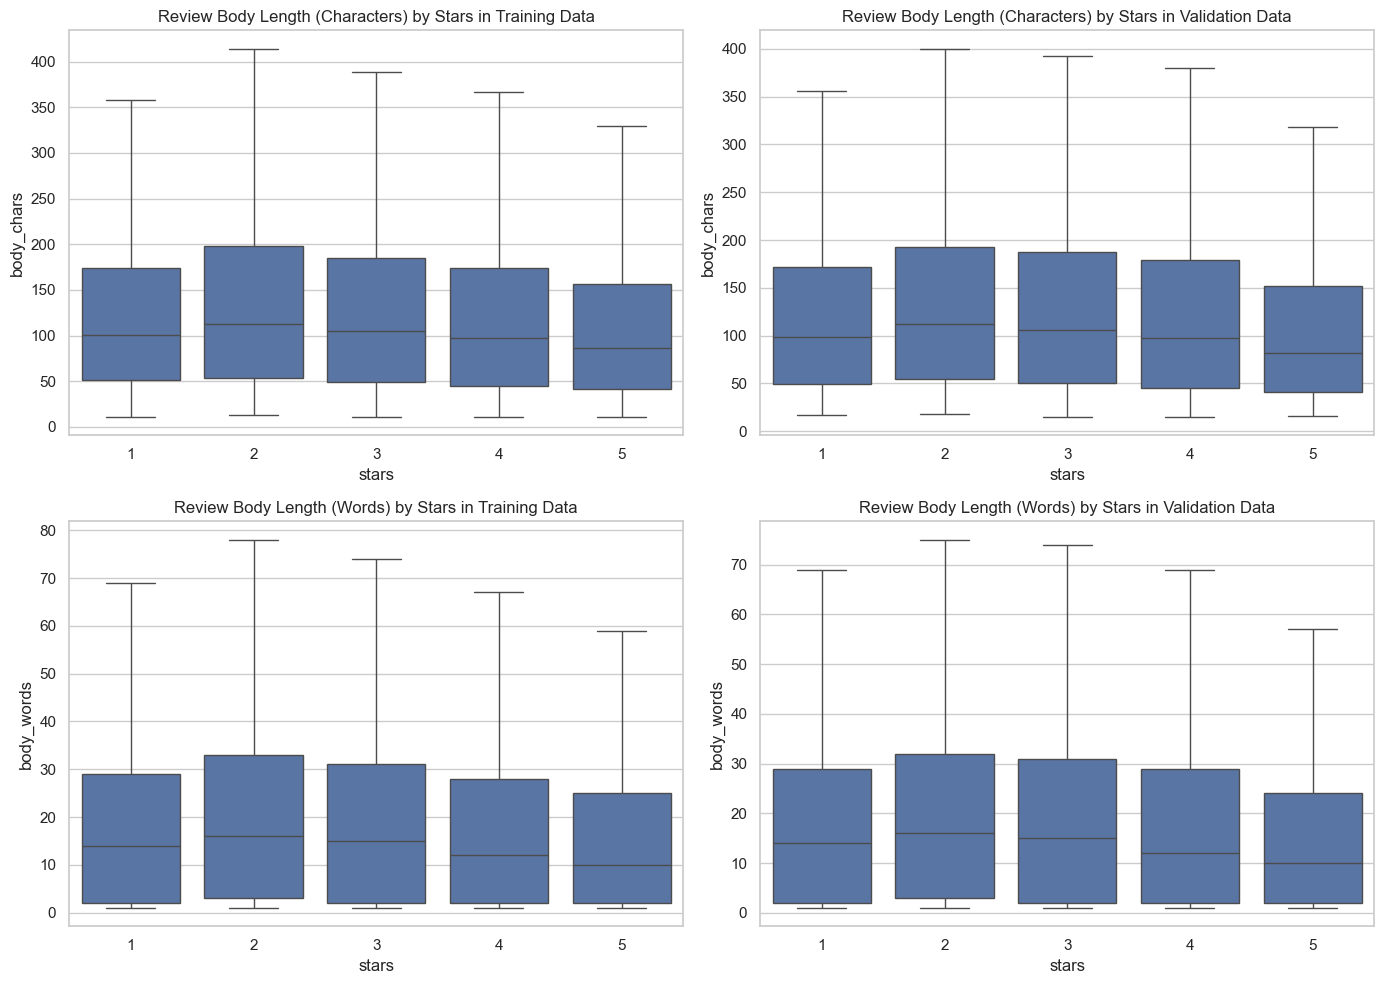

In [13]:
# Visualizing Distributions in data using boxplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  

# Body Length (Chars) 
sns.boxplot(data=train_df, x='stars', y='body_chars', ax=axes[0, 0], showfliers=False)  
axes[0, 0].set_title('Review Body Length (Characters) by Stars in Training Data')  

sns.boxplot(data=val_df, x='stars', y='body_chars', ax=axes[0, 1], showfliers=False)  
axes[0, 1].set_title('Review Body Length (Characters) by Stars in Validation Data')  

# Body Length (Words)  
sns.boxplot(data=train_df, x='stars', y='body_words', ax=axes[1, 0], showfliers=False)  
axes[1, 0].set_title('Review Body Length (Words) by Stars in Training Data')  

sns.boxplot(data=val_df, x='stars', y='body_words', ax=axes[1, 1], showfliers=False)  
axes[1, 1].set_title('Review Body Length (Words) by Stars in Validation Data')  


plt.tight_layout()  
plt.show()  

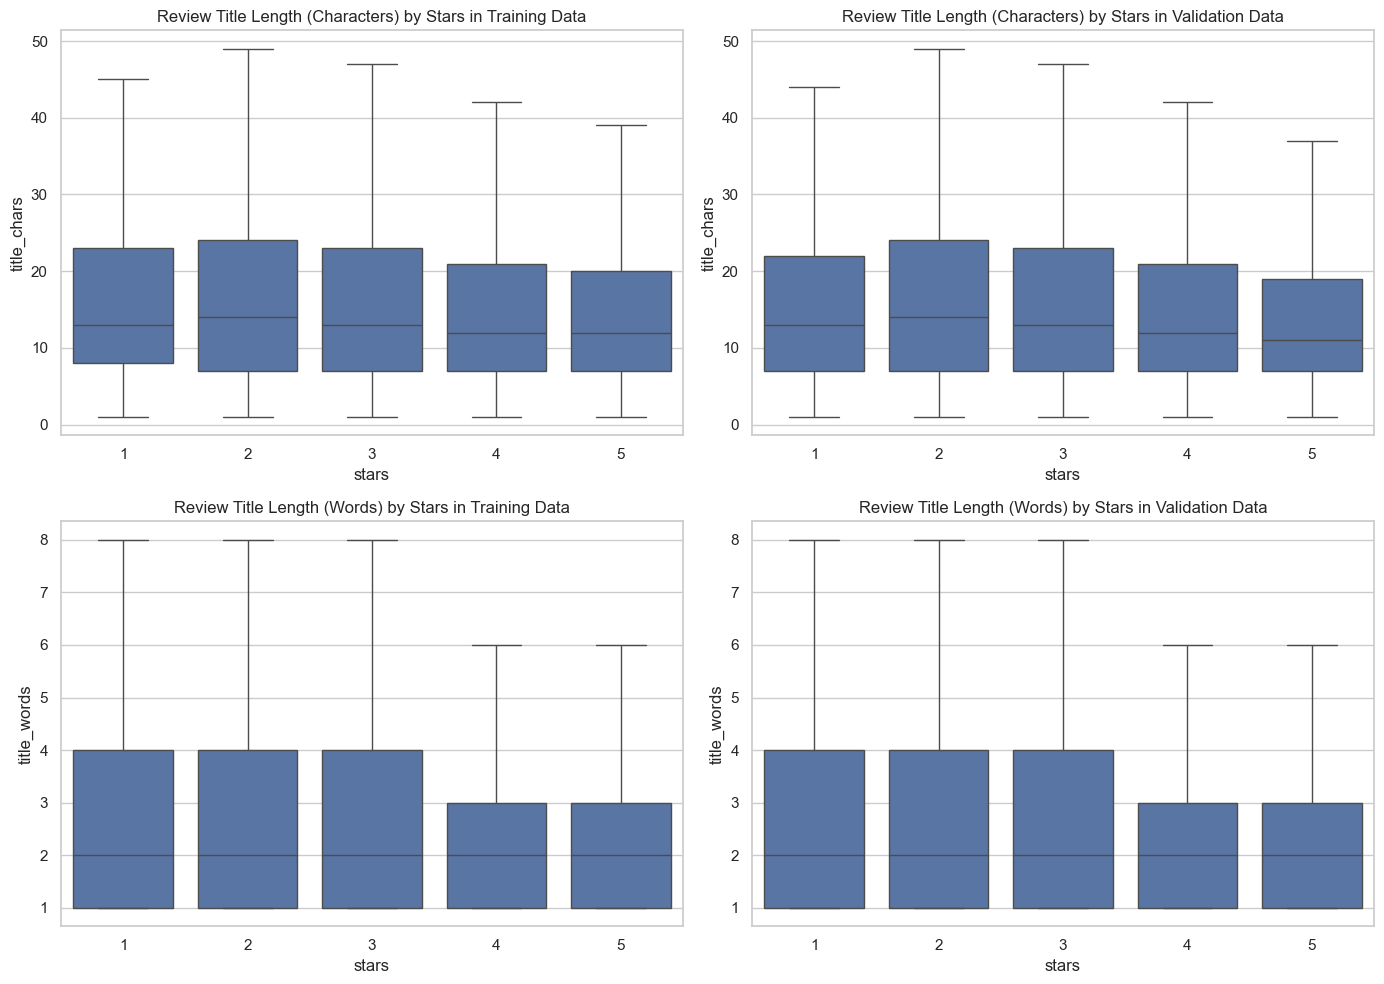

In [14]:
# Visualizing Distributions in data using boxplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  

# Title Length (Chars) 
sns.boxplot(data=train_df, x='stars', y='title_chars', ax=axes[0, 0], showfliers=False)  
axes[0, 0].set_title('Review Title Length (Characters) by Stars in Training Data')  

sns.boxplot(data=val_df, x='stars', y='title_chars', ax=axes[0, 1], showfliers=False)  
axes[0, 1].set_title('Review Title Length (Characters) by Stars in Validation Data')  

# Title Length (Words)  
sns.boxplot(data=train_df, x='stars', y='title_words', ax=axes[1, 0], showfliers=False)  
axes[1, 0].set_title('Review Title Length (Words) by Stars in Training Data')  

sns.boxplot(data=val_df, x='stars', y='title_words', ax=axes[1, 1], showfliers=False)  
axes[1, 1].set_title('Review Title Length (Words) by Stars in Validation Data')  

plt.tight_layout()  
plt.show()  

In [15]:
# Inspecting Outliers
print("Top 5 longest reviews in training data:")  
display(train_df.nlargest(5, 'body_chars')[['stars', 'body_chars', 'review_body']])  

print("Top 5 longest reviews in validation data:")  
display(val_df.nlargest(5, 'body_chars')[['stars', 'body_chars', 'review_body']])  

Top 5 longest reviews in training data:


,stars,body_chars,review_body
345529,4,3908,"Pros . A LOT of space. This bag can hold a ton of stuff, and it has so many pockets! Many of the pockets have elastic around the top, to better hold things like bottles and sippy cups. The main co..."
143641,4,3869,So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche Rückantwort wirft Zweifel am Erzeuger dieser Rückmeldung auf.nana nana So eine Dümmliche ...
720007,4,3864,J'ai acheté ce sac à dos pour remplacer mon Port Designs Chamonix acheté 10 ans plus tôt. J'ai décidé choisir un autre sac chez Port Designs car mon Chamonix était très bien pensé et ne montre que...
137538,4,3766,"Hallo zusammen, ich habe es mir angewöhnt meine Bewertungen erst nach einigen Wochen / Monaten zu schreiben, da häufig die Freude beim Auspacken und beim ersten Ausprobieren so groß ist, dass man ..."
305425,3,3724,Bottom line is it's probably just not for me but after spending 240 bucks and testing it in every way i can think of it gives me a lot to think about. From my experience it does allow pass through...


Top 5 longest reviews in validation data:


,stars,body_chars,review_body
7660,3,3657,"This movie is good. It is not great, but it covers a lot of bases. The directing is excellent, with camera work and scene structure that builds to a worthy end. The acting is great, with Renee Rus..."
8361,4,2661,"I ordered this to repaint some cabinet doors. They had your typical tongue-and-groove design, making it impossible to paint an even coat without it looking all globby. While I found out the paint ..."
9994,5,2440,"Firstly, I'm not your average joe when it comes to a car wash. This is the best product I have ever used on my Corvette. I've had corvettes for 6 years now and no product has done to my car what t..."
6541,2,2433,"I have several issues with this endoscope that caused me to return it: 1) There are two laws of civil engineering: F=MA and ""You can't push on a rope."" This device violates rule #2. It isn't nearl..."
5068,1,2192,Literally just got this an hour ago. Bought it because my friend needs a headset and honestly so do I. I didnt wamt to pay for two high priced headsets so I took a look at cheap ones. Main thing I...


**Observations**
1. Data follows same patterns in both training and validation dataset
2. Review body length by char and words follow same patterns
3. Star Rating vs. Length Relationship 
    - Pattern: 2-star > 3-star > 4-star > 1-star > 5-star in length (chars/words)
    - 2 star reviews are longest. Suggests dissappointed but invested customer
    - 5 star reviews are shortest. Suggests brief praise
    - 1 star reviews shorter than 2/3 star reviews. Suggests short intense negative emotion over constructive criticism
5. Top 5 outliers based on review length were all in English, French, and German languages in Training Dataset, but only English language in Validation dataset
    - Might be a sampling bias, need to investigate further



#### Review Length vs. Language Analysis
**Objective:**
1. Test if review length varies sytematically by language

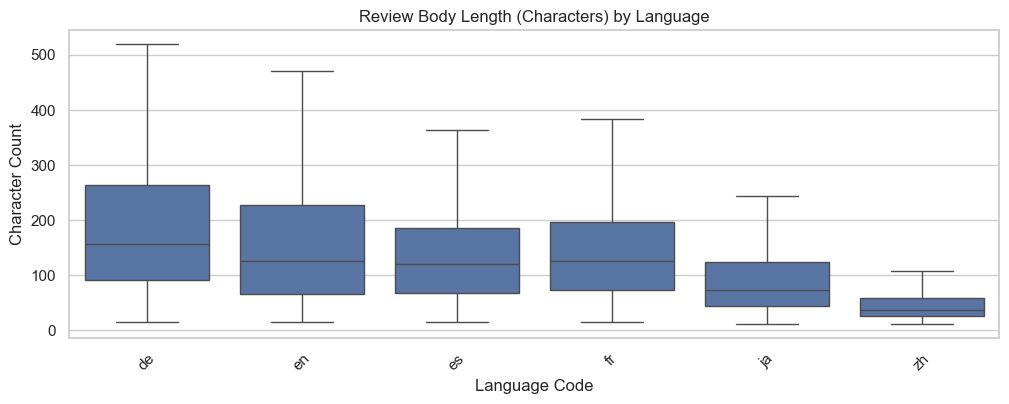

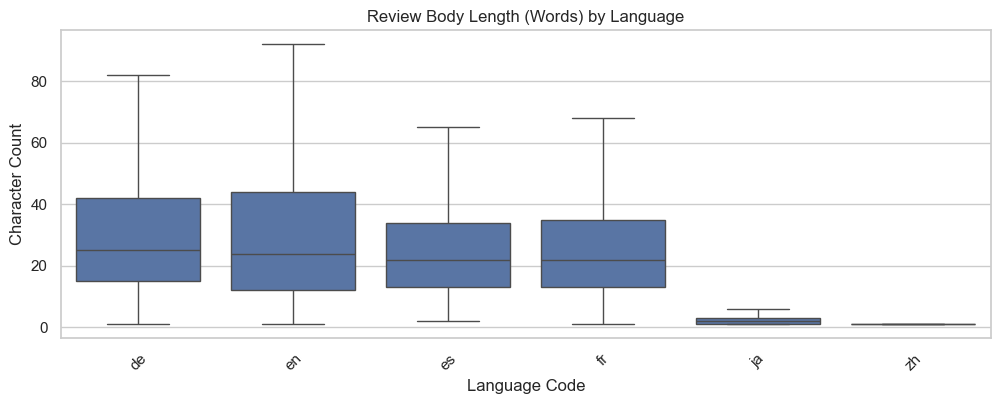

In [16]:
# Visualization using boxplot
plt.figure(figsize=(12, 4))  


sns.boxplot(  
    data=train_df,  
    x='language',  
    y='body_chars',  
    showfliers=False,  # Exclude extreme outliers
    order=train_df['language'].value_counts().index  # Sort by frequency  
).set(
title = 'Review Body Length (Characters) by Language',
ylabel = 'Character Count',
xlabel = 'Language Code'
)
plt.xticks(rotation=45)  
plt.show()  

# Word length by language  
plt.figure(figsize=(12, 4))  
sns.boxplot(  
    data=train_df,  
    x='language',  
    y='body_words',  
    showfliers=False,  
    order=train_df['language'].value_counts().index  
).set(
title = 'Review Body Length (Words) by Language',
ylabel = 'Character Count',
xlabel = 'Language Code'
)
plt.xticks(rotation=45)  
plt.show()  

In [17]:
# Statistical validation
from scipy.stats import f_oneway  

# Group word counts by language  
groups = [group['body_words'].values for name, group in train_df.groupby('language',observed=False)]  
f_stat, p_value = f_oneway(*groups)

print(f"\nStatistical Test Results:")
print(f"One-way ANOVA p-value: {p_value:.3e}")
print("Interpretation: p < 0.05 indicates significant length differences by language")


Statistical Test Results:
One-way ANOVA p-value: 0.000e+00
Interpretation: p < 0.05 indicates significant length differences by language


**Observations:**
1. German reviews are longest, both characters and words exceed other latin scripts(en/fr/es)
    - German language uses compound words which might have inflated character count
    - Cultural tendency for detailed feedback, possible.
2. French and Spanish are shorter than expected, all latin scripts have almost similar median length
    - French and Spanish were expected to have higher word count than English
    - Cultural tendency for short reviews, possible
3. Asian languages (zh/ja) are extremely concise as expected
    - These languages are known to be much denser than English and have a huge vocablary
    - Cultural tendency to be direct, and efficient, possible
4. Anova p-value = 0.000 -> Language is a dominant factor in review length variation
5. Future models might need language-specific length normalization

#### Word frequency analysis by star value
1. Identify specific words that dominate each star rating, and movement of those words in ranking across different star ratings
2. Identify if certain specific words can be used as a good signal for sentiment analysis

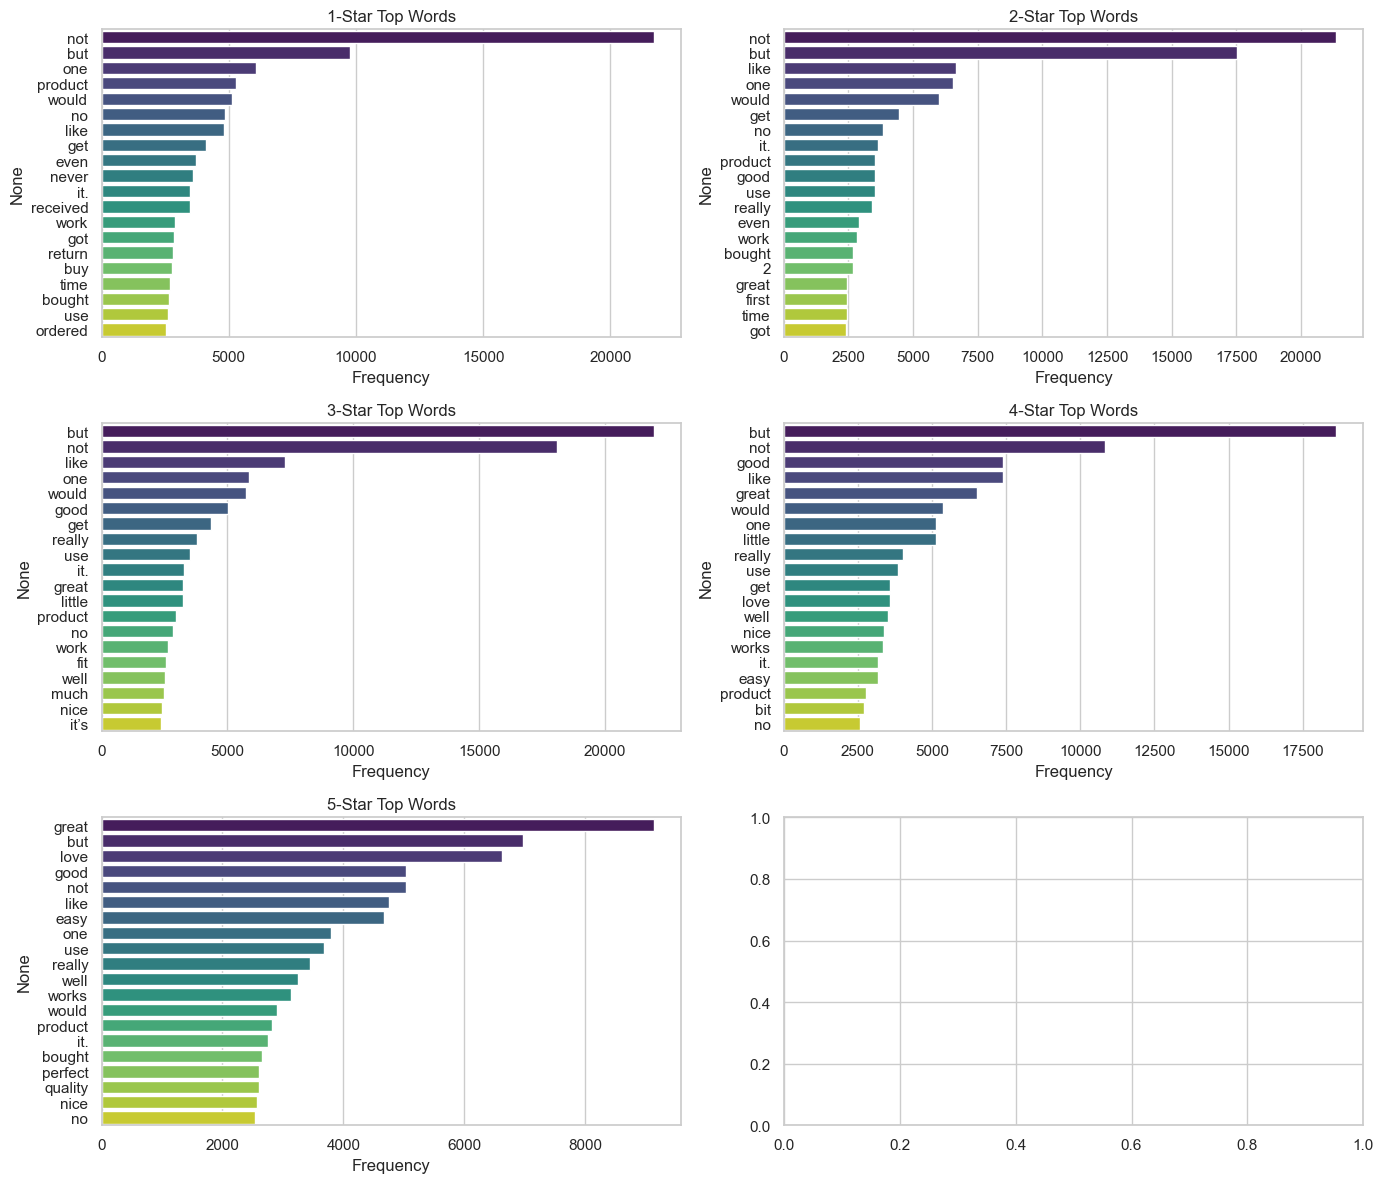

In [18]:
'''
Only focusing on English language reviews, to avoid cross linguistic noise and nuances

Pros: 
quicker, 
helps build general intuition on what to expect from other languages as well

Cons: 
cultural differences bring along a lot of language nuances
We cannot assume that insights generated on from English language reviews will be the same as other languages
'''

from collections import defaultdict  
import nltk
from nltk.corpus import stopwords

eng_train = train_df[train_df['language'] == 'en'].copy()  
star_words = defaultdict(list)  
stopwords = set(nltk.corpus.stopwords.words('english')) - {'not', 'no', 'but', "don't"}  # Keeping negations to preserve sentiment context

# tokenization
for star in range(1, 6):  
    texts = eng_train[eng_train['stars'] == star]['review_body'].str.lower()  
    words = texts.str.split(expand=True).stack()   
    words = words[~words.isin(stopwords)]  # Filter stopwords  
    star_words[star] = words.value_counts().head(20)  # Top 20 for each star

# creating bar plots for top 20 words for each star rating
fig, axes = plt.subplots(3, 2, figsize=(14, 12))  
axes = axes.flatten()  

for i, star in enumerate(range(1, 6)):  
    sns.barplot(  
        x=star_words[star].values,  
        y=star_words[star].index,  
        hue = star_words[star].index,
        ax=axes[i],  
        palette='viridis',
        legend = False
    )  
    axes[i].set_title(f'{star}-Star Top Words')  
    axes[i].set_xlabel('Frequency')  


plt.tight_layout()  
plt.show()  


**Observations:**
1. Star ratings 1/2:
    1. 'not' is the most frequently used word which is to be expected.
    2. There are no positive terms in 1 star reviews, but we do see 'good' among top 20 words in 2 star ratings. 
    3. Another interesting discovery is presence of the digit '2' among top 20 words. It might be a self referencial, in cases where reviewers presented the case of giving the product 2 stars instead and the only thing they found good about the product. Needs further investigation
    4. For future model use, will have to remove '2' else model will probably laern to predict 2 star ratings as soon as it comes across this number in review body.
2. Star ratings 3/4:
    1. But and not dominates in both 3 and 4 star ratings.
    2. Good seems to be climbung up the ranks as we progress through higher star ratings
    3. Indicates conflict within reviewer, probably due to them liking something a lot but being discontent with something in particular. 
    4. 4 star ratings have a lot more positive words than 3 star ratings, which is to be expected.
    5. 4 star ratings have a more healthy distribution of words as compared to ratings 1-3 indicating that for lower ratings, reviwers tend to overuse specific negative words. While for positive reviews, reviewers tend to use a mix bag of positive words to express themselves.
3. Star rating 5:
    1. 'Great' dominates the the frequency of words used in 5 star reviews
    2. Most of the words are positive.
    3. We do see 'not' and 'no' in the top 20 words but they can be part of double negation. Eg. There is nothing I don't like.
    4. Top word frequency distribution is much healthier as compared to ratings 1-3. Further supporting hypothesis that for positive reviews, reviewers tend to use a mix bag of positive words to express themselves

#### Review Self Referential Analysis

In [20]:
#Checking if reviews have a reference to the star rating within them
def self_reference_sampler(df: pd.DataFrame, random_state=12):
    
    star_samples = {} # a simple dictionary to store samples for each star rating
    
    # iterates over all star ratings (1-5)
    # checking only for English
    for i in range(1,6):
        star_samples[i] = df[
            (df['stars'] == i) & 
            (df['language'] == 'en') & 
            (train_df['review_body'].str.contains(fr'\b{i}\b', regex=True))
        ].sample(5, random_state=random_state)
    
    return star_samples


samples = self_reference_sampler(train_df,random_state)

#iterates over all star ratings (1-5) to display samples for each
for i in range(1,6):
    print(f"\n{i} star samples")
    display(samples[i][['review_body']])


1 star samples


,review_body
214482,"This is not a review for this Album. The Album is great and an all-time Classic. However when I ordered this on vinyl, side 1 is Marvin Gaye and Side 2 is a completely different artist!!! It’s lik..."
232528,I had new sod put in over the summer. I found this product while searching for solutions to have my dogs urine be less concentrated. I have a Bernedoodle who weighs 95 lbs. His recommended dosage ...
200781,Worked for 1 out of 4 ball joints. The clamp bent and was very difficult to hold all the parts in the correct sequence to instal the others.
224364,This is my 3 rd paint by numbers but it was my first bad experience. Not enough paint I had to buy like 3 different colors (mostly Brown). The quality was pretty low you still can see the numbers ...
211537,only 1 of the 4 cables worked....tried multiple chargers to confirm....the 1 working cable eventually stopped working after a few weeks. I guess you get what you pay for



2 star samples


,review_body
250899,"Sound great for voice calls, not so much for music. Light weight and comfortable. The adjustable microphone picks up the softest whisper while not allowing environmental sounds to drown out the co..."
261192,We bought this for our 12 year old because flossing with braces is a huge pain. This handy gadget works great for that but 2.5 months later a seal somewhere on the botttom has failed and the water...
278708,I replaced my old one that I had for a long time. This one lasted less then 2 weeks before zipper pulled off broken.
257912,Really disappointed because this mattress is so comfortable for a memory foam. Almost has a pillow top. Unfortunately I had to refund and amazon was out of stock. I ordered the 12 inch and after 2...
277013,"Lets jump right into it. It's a nifty little thing, however it gets a 2 star rating because if you don't seal it perfectly there are holes that let air out in say a chip bag. What I mean by this i..."



3 star samples


,review_body
302132,"In my quest for a quiet 2700k GU10 bulb, I was happy to see that Hyperikon had finally made a plastic-bodied bulb of regular size. Their older, metal-framed 2700k GU10 bulb was the quietest bulb I..."
291933,"This product is rather small but comes in a pack of 3. It looks and smells great, but the scent is one that can only be smelled up close. It is super faint when placed in a room (and I have a pret..."
300017,Installation was a bit tricky. Watch the video. I went through 3 before I got a decent installation (they give you 6 luckily). But there’s a crease in the middle from the installation I can’t get ...
305304,It's a case. Works well. Fit well. Reason for 3 stars was due to packaging damaged. And I was going away so I needed it to keep safe. So I kept a damaged case. Still worked.
307509,I left a review for these lights I really love them at first. Unfortunately turn on my TV lights go on... Then I have the timer on and I turn my TV off like 2 to 3 in the morning and the damn ligh...



4 star samples


,review_body
347924,Over the last few years I have just about switches all my casual no show socks over to Polo. I wear a size 15 shoe and it’s difficult to find socks that are the right size. These fit perfect.... t...
327887,"From my perspective, a weak 4 star - written well and grammatically correct, but with too dark a ""vibe"" to draw me into the story until the final 20% of the book. If the author can maintain a bala..."
347329,I hope that this review will help education people looking for smart wifi bulbs. Let's get the positives out there first. The lights appear to be high quality and the color selections are virtuall...
336674,Only 4 star because this item does not come with a on/off switch. I installed one and works great.
346733,"I love this thing! My dog doesn't run away when I try to wash her feet. I'm only giving it 4 stars because I wish it was a little taller to get the whole ""foot"" part of her back feet (she gets mud..."



5 star samples


,review_body
386156,Best shoe ever. Just wished they had more color variety. I usually wear size 9.5 shoe bought size 9 fit perfect. I have other expensive shoes for my Orange Theory workouts but these are so comfort...
395560,"This T-shirt is GREAT. I was really surprised., because I don't usually order T-shirts online. I'm a funny one to fit (5'3"" and over 200 lbs, most of it in the middle, which makes it hard to fit m..."
363714,"This masque really softens my hair. I wash my hair, put on the masque rinse it after 5 minutes and the difference in my hair is night and day. Cant live without this!!"
360700,"I was looking for a case that would be thinner and lighter than the one I had for my last iPad. This one fit the bill. Was delivered a day early, and the quality was just as advertised. Well worth..."
375244,"This pillow was highly effective for my mom. According to her opinion, this pillow was so comfortable. When she saw the shape of the pillow, she denied it yo use. But i requested her to try for a ..."


**Observation**
1. Reviews that contain the digit that is same as the rating number, do not necessarily refer to the star rating
2. Those numbers are often temporal or quantitative in nature and are not directly referencing to the star rating
3. There is a possibility that they might be indireclty refering to the star rating due to psychological anchoring. Reviewers who were thinking about giving two star ratings got fixated to that number and used it in often while not being able to think coherently. Viceversa can also be true, where reviewers whose device broke down in two weeks, or two months got fixated to that number and gave the review.
4. At this stage we cannot deny or prove that digits present in the rating do not signal to the rating itself. Except for reviews where digit + "star/s" are explicitly together.
5. Are small sample does have cases where reviewer has directly referred to the rating that they are giving: "four stars"
6. We will also have to consider cases where there might be other words in between the digit and "star/s". For example "two frickin stars", or "five pretty golden stars".
7. Particularly for the case of 2-star reviews we can consider generating negative samples where 2 appears in non rating context or downweight standalone digits. After further investigation this can be an oportunity to improve model performance.

#### Sentiment Lexicon Analysis
**Objectives**
1. Validate if sentiment lexicon like Vader and TextBlob display useful patterns to signal star values
2. Establish a rule-based sentiment baseline before training ML Models

/var/folders/wl/lf_n4kbn0h9_ybhjh1nxh9w40000gn/T/ipykernel_15768/766140154.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(500, random_state=random_state))


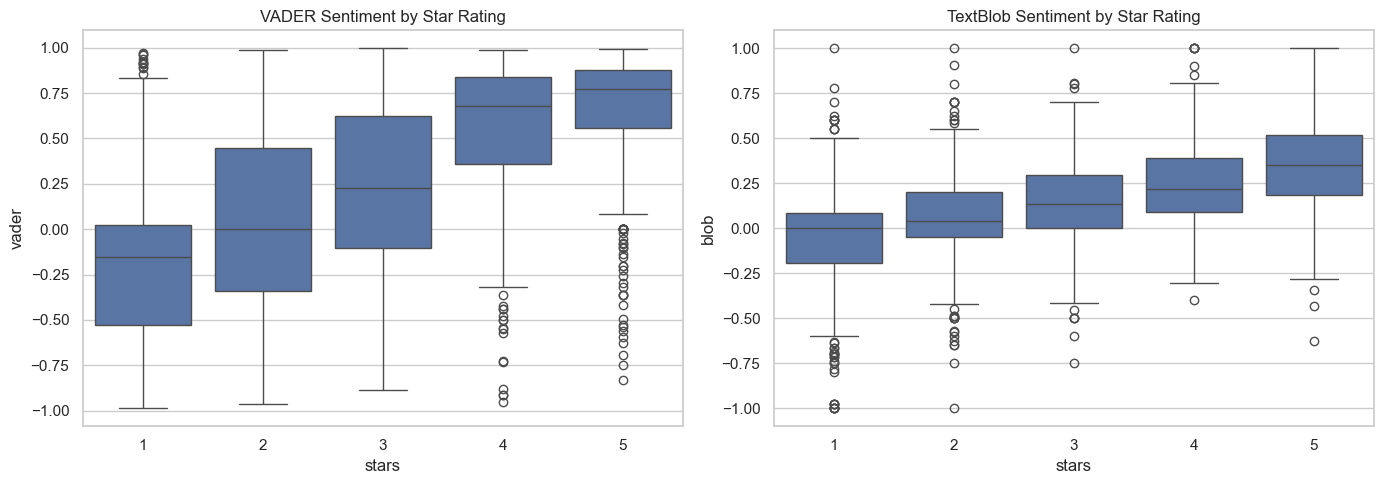


Negation Test:


,text,vader,blob
0,good,0.4404,0.70
1,not good,-0.3412,-0.35
2,not bad,0.4310,0.35
3,bad,-0.5423,-0.70


In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer  
from textblob import TextBlob  

# Initializing VADER
vader = SentimentIntensityAnalyzer()  

def analyze_sentiment(text):  
    vader_score = vader.polarity_scores(text)['compound']  # Range: [-1, 1]  
    blob_score = TextBlob(text).sentiment.polarity          # Range: [-1, 1]  
    return pd.Series([vader_score, blob_score], index=['vader', 'blob'])  

# Sample 500 reviews for each star rating
sample_reviews = (  
    train_df[train_df['language'] == 'en']  
    .groupby('stars')  
    .apply(lambda x: x.sample(500, random_state=random_state))  
    .reset_index(drop=True)  
)

# Calculate sentiment scores
sentiments = sample_reviews['review_body'].apply(analyze_sentiment)  
sample_reviews = pd.concat([sample_reviews, sentiments], axis=1)  

# Visualization distribution using boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(data=sample_reviews, x='stars', y='vader', ax=axes[0])
axes[0].set_title('VADER Sentiment by Star Rating')

sns.boxplot(data=sample_reviews, x='stars', y='blob', ax=axes[1])
axes[1].set_title('TextBlob Sentiment by Star Rating')

plt.tight_layout()
plt.show()

# Checking negation handling for Vader and text_blob
negation_examples = [
    "good", "not good", "not bad", "bad"  
]  
print("\nNegation Test:")  
display(pd.DataFrame([  
    {  
        'text': text,
        'vader': vader.polarity_scores(text)['compound'],  
        'blob': TextBlob(text).sentiment.polarity
    } for text in negation_examples
]))  

**Observations:**
1. Vader:
    1. Shows good gradation across star ratings
    2. Handles negation well
    3. Wider IQR for 2-3 stars might be due to mixed/neutral sentiment
2. TextBlob:
    1. Poorer discrimination between 5-star review and 1-star review
    2. Sentiment graduation is present but the resolution is poor
    3. Negation handling is well, but absolute scores less meaningful
3. Outlier Analysis:
    1. Positive outliers in 1 star reviews likely represent negation that was not understood simply on the basis of lexicon
    2. Negative outliers in 4-5 star reviews likely represent double negation that was not very apparent, out of which one was not understood simply on the basis of lexicon
    3. There migh also be cases where reviewer wished to give a lower star rating but gave a higher star rating and went onto give a negative review.
4. Vader outperformed Textblob on the sample dataset.
5. Vader will be good a baseline to train ML Models
2. Vader's sentiment score will be useful as a feature in the sample dataset, to train ML models

#### Key Takeaways
1. Star Rating vs. Length Relationship: Pattern: 2-star > 3-star > 4-star > 1-star > 5-star in length (chars/words)
2. Language is a dominant factor in review length variation. Future models might need language-specific length normalization
3. For lower rated reviews, reviewers tend to use certain words more frequenetly, as rating become positive towards 4/5, reviewers use a mix bad of positive words to express themselves
4. Vader sentiment scores is a good baseline for training ML models (Only for English, nead to use contemparies for other languages)
5. Vader sentiment scores is a good feature to add to dataset to signal star rating (Only for English, nead to use contemparies for other languages)

### Feature Relationships
**Objectives:**
1. Determine how critical features correlate with each other
2. Identify if there is correlation between product category and star rating, i.e., if certain categories are more prone to lower ratings than others
3. Investigate if certain reviewers affect ratings more than other reviewers, by spamming reviews or giving extreme ratings
4. Identify if a reviewer who speak a particular language is more/less likely to review certain product categories

#### Product Category vs Star correlation

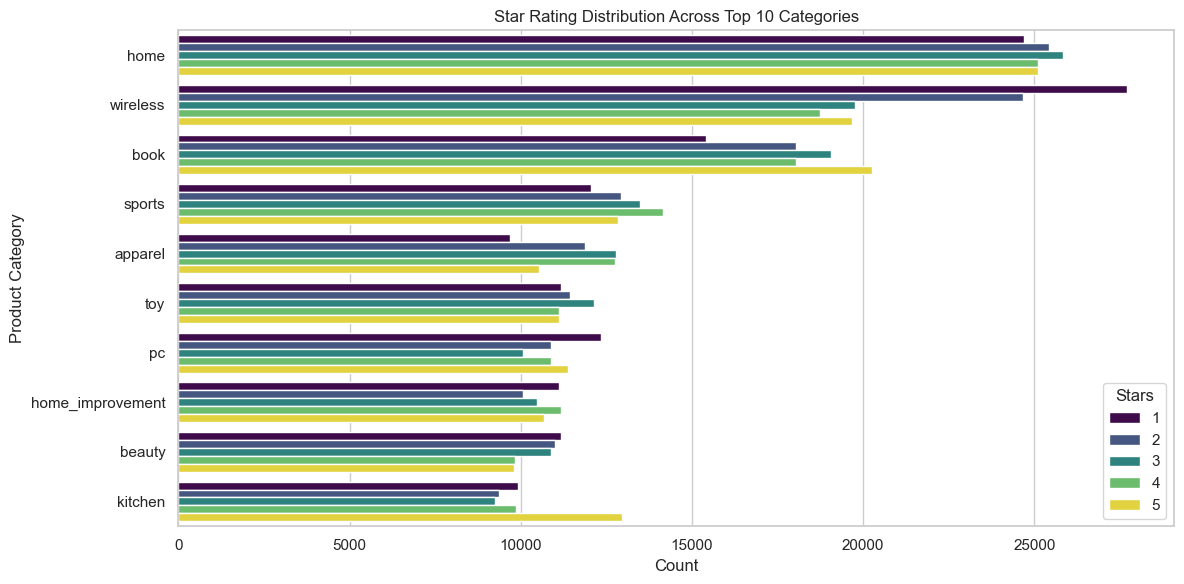

/var/folders/wl/lf_n4kbn0h9_ybhjh1nxh9w40000gn/T/ipykernel_15768/745776984.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['product_category', 'stars'])


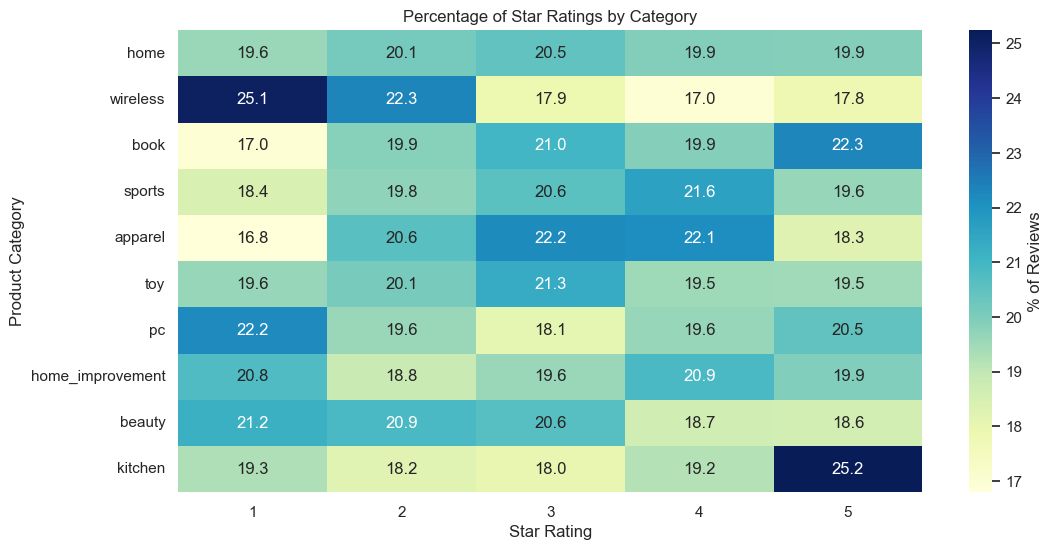

In [23]:
# 1. Get top 10 categories  
top_categories = train_df['product_category'].value_counts().nlargest(10).index  

# 2. Plot rating distribution per category using countplot
plt.figure(figsize=(12, 6))  
sns.countplot(  
    data=train_df[train_df['product_category'].isin(top_categories)],  
    y='product_category',  
    hue='stars',  
    order=top_categories,  
    palette='viridis'  
)  
plt.title('Star Rating Distribution Across Top 10 Categories')  
plt.xlabel('Count')  
plt.ylabel('Product Category')  
plt.legend(title='Stars')  
plt.tight_layout()  
plt.show()  

# 3. Normalized view (percentages)  
category_ratings = (  
    train_df[train_df['product_category'].isin(top_categories)]  
    .groupby(['product_category', 'stars'])  
    .size()  
    .unstack()  
    .apply(lambda x: x / x.sum() * 100, axis=1)  
)  

plt.figure(figsize=(12, 6))  
sns.heatmap(  
    category_ratings.loc[top_categories],  
    annot=True,  
    fmt='.1f',  
    cmap='YlGnBu',  
    cbar_kws={'label': '% of Reviews'}  
)  
plt.title('Percentage of Star Ratings by Category')  
plt.xlabel('Star Rating')  
plt.ylabel('Product Category')  
plt.show()  

**Observation:**
1. There isn't a complete uniform distribution in star rating across product categories, as noticed for languages
2. Most extreme deviation is in wireless category where 25.1% of the reviews are 1 star and kitchen where 25.2% reviews are 5 star
3. Categories seem to display a pattern and degrees of skewness
    - 'wireless' has a significant right skew, indicative of wirless products in general failing to meet reviewer expectations.
    - 'kitchen' has a significant right skew, indicative of kitchen products in general meeting reviewer expectations.
    - 'pc' has a u shaped distribution, indicative of it being a hit or a miss. 
    - 'apparel' has a bell shaped distribution, indicative of it having an moderate response from reviewers. Neither too bad nor too good
4. There isn't any extreme, none of the categories from the sample exceeds ±5% deviation from balanced baseline.
5. Category specific thresholds don't seem necessary at this stage. It might be an improvement item for future enhancement of model

#### Reviewer Behavior Analysis

Text(0.5, 0, 'Number of Reviews')

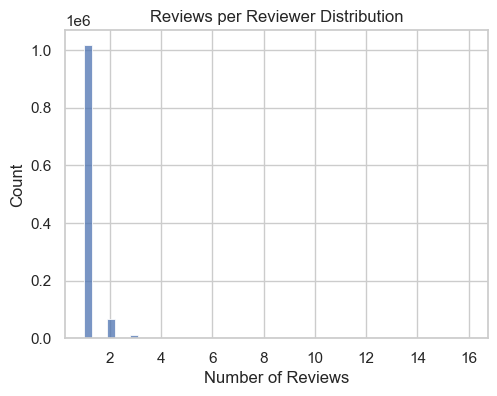

In [25]:
#counting number of reviews per reviewers 
reviews_per_reviewer = train_df['reviewer_id'].value_counts()  

#Visualizing number of reviews per reviewer using histogram
plt.figure(figsize=(12, 4))  
plt.subplot(1, 2, 1)  
sns.histplot(reviews_per_reviewer, bins=50)  
plt.title('Reviews per Reviewer Distribution')  
plt.xlabel('Number of Reviews')  


Data is extremely right skewed, a very big majority of reviewers had given only 1 review, while a smaller but still significant percentage of reviewers gave 2 reviews

In [26]:
#finding cumulative percentage for number of reviewers who gave less than 4 reviews
for i in range(1,5):
    filter_mask = reviews_per_reviewer <= i
    percent_leqx = (filter_mask.sum() / len(reviews_per_reviewer)) * 100
    print(f"number of reviewers who gave {i} or less reviews: {percent_leqx:.2f}%")

number of reviewers who gave 1 or less reviews: 92.63%
number of reviewers who gave 2 or less reviews: 98.74%
number of reviewers who gave 3 or less reviews: 99.64%
number of reviewers who gave 4 or less reviews: 99.86%


**Observation:**
1. Extreme right-skew, 92.6% of reviewers gave only 1 review
2. 99.64% of the reviewers wrote $\leq$ 3 reviews
3. The "long tail" of power users is negligible
4. No evidence of review bombing or power-user skew
5. No need for reviewer-based filtering

**Action Items:**
1. Can safely ignore reviewer_id as a feature

#### Language-Category Correlation Analysis
**Objective:**
1. Identify if certain languages dominate specific product categories
2. Identify if rating distributions vary significantly by language-category pairs
3. Identify if potential biases exist in multilingual coverage

In [27]:
# normalized pivot table: language % per product category
pivot = (
    train_df.groupby(['product_category', 'language'])
    .size()
    .unstack()
    .fillna(0)
    .apply(lambda x: x / x.sum() * 100, axis=1)
)

# Filtering categories with meaningful multilingual data
min_reviews = 100  # Minimum reviews to consider a category
valid_categories = train_df['product_category'].value_counts()[train_df['product_category'].value_counts() > min_reviews].index
pivot_filtered = pivot.loc[valid_categories]

print("Language Distribution by Product Category (%):")
display(pivot_filtered.style.background_gradient(cmap='Blues', axis=1, vmin=0, vmax=100))

Language Distribution by Product Category (%):


/var/folders/wl/lf_n4kbn0h9_ybhjh1nxh9w40000gn/T/ipykernel_15768/407903297.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['product_category', 'language'])


language,de,en,es,fr,ja,zh
product_category,,,,,,
home,20.655904,14.011270,21.368395,22.657854,14.790334,6.516243
wireless,18.060757,14.218640,23.418191,23.707684,14.775914,5.818813
book,5.425853,4.136291,5.796974,9.041253,6.157082,69.442548
sports,21.009842,12.649001,20.155572,12.866006,24.127392,9.192188
apparel,17.667992,27.689343,9.958859,10.017880,14.175361,20.490565
toy,17.174413,15.355305,23.962705,21.953960,15.109480,6.444136
pc,15.433754,11.518183,20.137477,17.438324,26.797186,8.675076
home_improvement,23.199462,13.342308,20.340663,24.502655,12.558896,6.056017
beauty,13.591680,22.945686,13.923786,15.612783,16.085323,17.840741


<Figure size 1200x600 with 0 Axes>

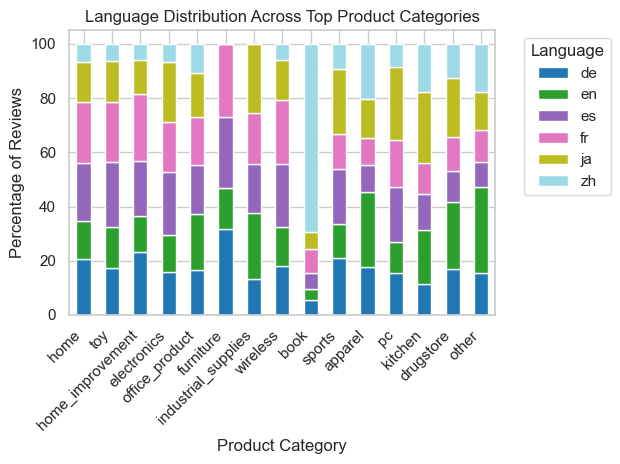

In [29]:
# visualizing top 15 categories using stacked barplots
top_categories = pivot_filtered.sum(axis=1).nlargest(15).index
pivot_vis = pivot_filtered.loc[top_categories]

# Stacked bar plot
plt.figure(figsize=(12, 6))
pivot_vis.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Language Distribution Across Top Product Categories')
plt.ylabel('Percentage of Reviews')
plt.xlabel('Product Category')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [30]:
from scipy.stats import chi2_contingency

# Chi-square test for language-category dependence
contingency_table = train_df.groupby(['product_category', 'language'], observed=False).size().unstack().fillna(0)
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"\nStatistical Test Results:")
print(f"Chi-square p-value: {p:.3e}")
print("Interpretation: p < 0.05 indicates language distribution varies significantly by category")


Statistical Test Results:
Chi-square p-value: 0.000e+00
Interpretation: p < 0.05 indicates language distribution varies significantly by category


**Observations**
1. Extreme Dominance Cases:
    1. Chinese (zh) Dominance: Books: 69.4% and Digital eBooks: 55.4%
    2. Japanese (ja) Dominance: Automotive: 31.6% and Shoes: 27.5%
    3. German (de) Dominance: Furniture: 31.7% and Lawn & Garden: 30.3%
2. Complete Absences:
    1. Personal Care Appliances: No Japanese reviews
    2. Digital Video Downloads: Only English, German, Japanese
    3. Pet Products: Almost no Chinese (0.9%)
3. Statistical Confirmation:
    1. Chi-square p-value = 0.000 → Significant variation in language by category
4. Language dominance might be due to cultural differences.
5. Artificial class balancing might have dampened the correlation between class category and language. Real imabalance might have been more extreme.
5. While building ML models, taking care of this imbalance will be a must

### Core Discoveries from Foundational EDA
1. Dataset Structure & Balancing
    1. Dataset is clean with very miniscule missing values
    1. Artificial Balancing Confirmed:
        1. Perfectly uniform distributions:
            1. 20% per star rating (1-5)
            2. 16.67% per language (6 languages)
            3. 16.67% per language per star rating.
        3. True imbalances in product category and language likely more extreme than observed

2. Text Analysis Insights
    1. Review Length: 
        1. 2-star reviews are longest (detailed critiques), 5-star shortest (brief praise)
        2. Created new features based on review length and review title length
    2. Review and Review title length vary by language
        1. German was identified to have longest reviews while Mandarin and Japanese were identified as having shortest reviews
    2. Word Frequency: 
        1. Negation dominates low ratings ("not good"), opposite is true for higher rated reviews
        2. Digits in a review aren't necessarily self referencing, though they do sometimes refer to review rating explicitly.
    3. Sentiment Lexicons:
        1. VADER outperforms TextBlob for negation handling
        2. Scores align with star ratings but likely struggle with sarcasm, backhanded compliments, complex lexicon.

3. Feature Relationships
    1. Product Categories:
        1. Wireless products: Highest 1-star rates (25% vs 20% baseline)
        2. Kitchen products: Highest 5-star rates (25%)
        3. Deviation was within $\pm$5% of 20% for each star rating
    2. Reviewer Behavior:
        1. 92.6% of reviewers wrote only 1 review → minimal power-user bias
    3. Language-Category Imbalances:
        1. Extreme cases (Chinese books: 69%, Japanese automotive: 31%)
        2. Some categories missing languages (e.g., no Japanese pet products)

4. Modeling Challenges:
    1. Negation handling critical (esp. for 2-4 star reviews)
    2. Language-category pairs may need separate treatment

5. Preprocessing:
    1. Remove numeric rating references, when explicitly present within the review
    2. Expand contractions for negation clarity ("don't" → "do not")
    3. Feature Engineering: Use VADER scores as auxiliary features

## Problem Statement (1-3)

Problem Statement-1: Given this balanced dataset of product reviews, how would you build a sentiment analysis model to predict star ratings? What potential biases should you consider given that the dataset was artificially balanced?

Problem Statement-2: How would you leverage both review_body and review_title fields to improve classification accuracy? What architectures would you consider for combining these text features?

Problem Statement-3: If you needed to build a multilingual review classification system using this dataset, what approach would you take considering the language field? What challenges might you face?


### Boons and Banes of artifically balanced yet large dataset

**Benefits of Aritficially Balanced Dataset while building sentiment analysis model**
1. Since the dataset is artificially balanced it will force our models to distinguish all sentiment classes
2. It will improve recall on rare sentiments that would have been otherwise underrepresented
3. Model will converge faster.

**Detriments of Aritficially Balanced Dataset while building sentiment analysis model**
1. Model will likely underperform signficantly on real world data when compared to metrics established in training and validation 
2. Precision is likely to drop on rare sentiments since model will think that those sentiment classes are more likely to occur than in reality
3. Threshold calibration will be hard due to mismatch with real world distribution

**Effects of Large Dataset**
1. Detriments are likely to dampen due to large amount of training samples (1.2 million) available, that is if we train model on larger than usual dataset and let it converge
2. Model will still be biased but classification can be improved by validating on weighted dataset that simulates real world expectations

### PS1 - Potential Biases introduced via artificial balancing
1. In reality, in general 1 and 2 star ratings are much less than 3-5 star ratings, primary reason being ratings are self enforcing products that are rated higher are chosen by more people, who in turn at times give their own often satisfactory review. People tend to stay away from low rated products
2. This might cause our model to take negative sentiments as a much stronger signal than they usually are. Which will reduce our classification accuracy.
3. Feature importance will be dampened, features that would have been a strong signal for ratings are likely to be dampened, again reducing our classification 

### PS2 - Using review body and title for star rating classification
1. Review Title is expected to be a strong signal for star rating, but it is short and less nuanced
2. Review Body is expected to be a comparatively weaker signal for star rating but it captures nuances more accurately
3. Leveraging both these features is imperative to build a robust sentiment classification model
4. Translating all languages except English to English anther approach, but it isn't well suited for our model; it might be well suited in real world, but even then I think it won't be a good idea. Translators though highly accurate nowadays aren't perfect, we will be very well introducing garbage to our model, which doesn't bode well.
5. Possible Architectures:
    1. Encoding them together after concatenating them
        1. Without a placeholder (special token) in between: [Review Title] + [Review Body]
            1. Probably not a good architecture, if they will be encoded together, review title will lose its strong signal and will be treated just like review body. It will still probably work better than standalone [review title] or [review body] embeddings for classification
        2. With a placeholder (special token) in between: [TITL] + [Review Title] + [BODY] + [Review Body]
            1. Should work very well with BERT family of models; Title won't be treated as an extension of Review Body
    2. Encoding them separately:
        1. Encoding both title and body separately using **sparse** embeddings but using them together for classification:
            1. It doesn't dampen the signal present in Title, while body maintains its nuances. It might work better for classical models than concatenation, since model will be able to learn the features separately and learn to weight them on their own. 
        2. Encoding both title and body separately using **vector** (dense) embeddings but using them together for classification:
            1. Encoding both Title and Body using BERT and using the embeddings as input for MLP for our classification task should work well. 

### PS3 - Building Multilingual review classification System
1. A portion of our task has been made easier due to artificial balancing.
2. Unlike balancing star rating where the feature space use to classify star rating is common for all classes; languages can be handled independent of each other
3. For our dataset we are fortunate enough to know which language we are dealing with for each sample, but in real world we will probably need another langauge identifiction layer
4. I have approached this by treating each langauge separately and using it as the driver of my processing pipeline
    1. Each step of the data pipeline will identify langauge of the sample before processing it to ensure that signal isn't distorted
    2. Will use pretrained XLM-RoBERTa for multilingual classification since it has been trained on all of the languages we need and is battle tested
5. Nuances:
    1. Japanese, and Mandarin are high entropy languages and are known to convey a comparatively more information in shorter sentence/word lengths. Latin languages: English/French/Spanish are similar in entropy, while German is known to have less entropy than rest of the 5.
        1. Since review length is a strong signal for star rating, review lengths have to be normalized for each particular language and only then scaled down
    2. Negative words are a very strong signal for star rating. I am handling negation by combining the negative word with the word on its right. This forces our model to treat it specially. 
        1. For this exercise I am using regex, since it can be easily used for all languages due to its rule based nature. However Chinese and Japanese langauge don't have whitespace between words. So they are to be handled a bit differently
    3. French and English are known to have contracion (l'garcon; don't), so if the pipeline recieves those langauges it fixes the contractions
    4. There are probably a lot more nuances like idioms, specific ways of expressing dissapointment, and other cultural nuances that can be researched into, in future. 

## PS (1-3) Solution Architecture:
1. Data Processing
    1. Remove any instances of standalone digits from 1-5 along with digit followed by hyphen as in (5-star) to remove labels from within review body
        1. Probably would have been better to dive deeper and understand the nuances better than removing all the digits, deferring it to the future
    2. Expand contractions (don't -> do not) for English and French
    3. **Concatenate review title and body with [TITL] and [BODY] placeholders for transformer model to learn them. There are other architectures we could have chosen**
        1. **encoding them separately concatenating them and then sending them to a classical classifier, probably better for a classical classifier since they are not context aware.**
        2. **Encoding separately via a BERT can also work if we build a deep learning classifier on [CLS] embeddings, with enough training that might be better than concatenation.**
    4. Not going for stemming, lemmatization and stopword removal, since this is Sentiment classification problem, and sentiment signals can get lost during those processes. 
2. Feature Engineering and Feature selection
    1. Prebuilt features: Body_length (char and words) and title_length (char and words)
    2. Engineer: Normalized total (title + body) char length for each language separately, since we earlier discovered that length of title and review is heavily dependent upon language
    3. TFIDF features: 500 features, that will be used with Logistic regression. Number of features can be finetuned
    4. Our classifier will predict labels based on TFIDF features and normalized total char length
    5. Other features that can be engineered:
        1. number of punctuations (?!*)...
        2. Sentiment Lexicon scores specific for each language, like Vader for english
3. Model:
    1. Classical:
        1. Logistic Regression (implemented)
        2. XGBClassifier (implemented)
        3. RandomForest Ensemble
    2. Transformers:
        1. Language specific BERT models finetuned for sentiment analysis 
        2. XLM-RoBERTa 
4. Training
    1. Training on subset of training data with sample size = 120,000
    2. Using stratified sampling to preserce Language and star artificial balancing
5.  Evaluation
    1. F1 score, Recall, Precision

### Data Processing

In [31]:
#Dataprocessing libraries
import regex as re
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix


# 1. Basic Text Cleaning
def clean_text(text, lang):
    
    """Language-aware cleaning"""
    
    text = str(text)
    
    # Removing reference of rating from review; ([1-5] star; [1-55]-star; star) will be removed
    text = re.sub(r'\b[1-5](?:-?star| star)\b', '', text)
    text = re.sub(r'\bstar\b', '', text) 
    
    # expanding contractions for French and English Language
    if lang in ['en', 'fr']:
        text = contractions.fix(text)  # Only expand contractions for these
    return text

# Merging negations with the following word; did not like -> did not_like
def mark_negations(text, lang):
    
    """Merge negation terms with following words"""
    
    patterns = {
        'en': (r"\b(not|never|no)(\s+)(\w+)", r"\1_\3"),
        'de': (r"\b(nicht|kein)(\s+)(\w+)", r"\1_\3"),
        'fr': (r"\b(pas|non)(\s+)(\w+)", r"\1_\3"), 
        'es': (r"\b(no)(\s+)(\w+)", r"\1_\3"),
        'ja': (r"(ない|ず)(\p{Han}+)", r"\1_\2"), #Japanese and Mandarin doesn't have whitespace
        'zh': (r"(不|没)(\p{Han}+)", r"\1_\2"), #Japanese and Mandarin doesn't have whitespace
    }
    pattern, repl = patterns[lang]
    return re.sub(pattern, repl, text, flags=re.IGNORECASE)

#Preprocessing function
def preprocess_data(df):
    
    """Main preprocessing function"""
    
    # Combine title + body with placeholders
    df['full_text'] = '[TITL] ' + df['review_title'] + ' [BODY] ' + df['review_body']
    
    # call mark_negation and clean_text on language and text
    df['processed'] = [
        mark_negations(clean_text(t, lang), lang) 
        for t, lang in zip(df['full_text'], df['language'])
    ]
    
    # Review Length feature normalized on language
    for lang in df['language'].unique():
        mask = df['language'] == lang
        df.loc[mask, 'norm_chars'] = (
            df.loc[mask, 'body_chars'] - df.loc[mask, 'body_chars'].mean()
        ) / df.loc[mask, 'body_chars'].std()
    
    return df

#Feature Extraction
def extract_features(df, tfidf=None, scaler=None, n_features=500, is_train=False):
    
    """Create final feature matrix"""
    
    # TF-IDF
    if is_train:
        tfidf = TfidfVectorizer(
            max_features=n_features,
            ngram_range=(1, 2),
            token_pattern=r'\b\w+\b'
        )
        X_text = tfidf.fit_transform(df['processed']).astype(np.float32) #for training set
    else:
        X_text = tfidf.transform(df['processed']).astype(np.float32) # for validation set
    
    # scaling normalized review length feature
    if is_train:
        scaler = StandardScaler()
        X_lengths = scaler.fit_transform(df[['norm_chars']]).astype(np.float32) #for training set
    else:
        X_lengths = scaler.transform(df[['norm_chars']]).astype(np.float32) #for validation set
    
    X_lengths_sparse = csr_matrix(X_lengths) #converting scaled down length feature to sparse matrix
    
    # Combine sparse tfidf features with sparse length feature
    return (hstack([X_text, X_lengths_sparse], format='csr'),tfidf,scaler)

### Data loading for training and validation

In [32]:
%%time

from sklearn.model_selection import train_test_split #for selecting stratified subsample from training set

#compbining 'language' and 'star' to create a stratification column to preserve artificial balancing
stratify_col = train_df['stars'].astype(str) + "_" + train_df['language'].astype(str) 

train_subset, _ = train_test_split(
    train_df,
    train_size=120000,
    stratify=stratify_col,
    random_state=random_state
)

tfidf_features = 500 #tfidf features to be created

#processing data and splitting features and labels
train_processed = preprocess_data(train_subset)
X_train, tfidf, scaler = extract_features(train_processed, n_features = tfidf_features, is_train=True)
y_train = train_subset['stars']

val_processed = preprocess_data(val_df)
X_val, _, _ = extract_features(val_processed, tfidf=tfidf, scaler=scaler)
y_val = val_df['stars']


CPU times: user 10.1 s, sys: 642 ms, total: 10.7 s
Wall time: 10.9 s


In [33]:
#checking shape and size of feature and labels
sparse_size = (X_train.data.nbytes + 
               X_train.indptr.nbytes + 
               X_train.indices.nbytes) / (1024 ** 2)

print(f"X_train (10000 samples) memory usage: {sparse_size:.2f} MB")
print(f"y_train (10000 samples) memory usage: {y_train.memory_usage(deep=True) / (1024 ** 2):.2f} MB")

print(f"Shape of X_train is :{X_train.shape}")
print(f"Shape of y_train is :{y_train.shape}")

X_train (10000 samples) memory usage: 12.37 MB
y_train (10000 samples) memory usage: 1.03 MB
Shape of X_train is :(120000, 501)
Shape of y_train is :(120000,)


With sample size of 120,000:
1. Processing took 10.9 seconds, while CPU time was 10.7 seconds.
2. Currently with 500 tfidf features + 1 norm_char feature; X_train is using 12.31 MB; y_train is 1.03 MB.

### Logistic Regression Architecture

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2


# Ordinal logistic regression (since stars are ordered)
model = LogisticRegression(
    solver='saga', 
    max_iter=250,
    penalty='elasticnet',  # L1+L2 regularization
    l1_ratio=0.5
)


### Logistic Regression - training and eval

In [35]:
#training model
model.fit(X_train, y_train)

#evaluating model
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           1       0.49      0.42      0.45      6000
           2       0.38      0.22      0.28      6000
           3       0.37      0.22      0.28      6000
           4       0.32      0.30      0.31      6000
           5       0.34      0.68      0.45      6000

    accuracy                           0.37     30000
   macro avg       0.38      0.37      0.36     30000
weighted avg       0.38      0.37      0.36     30000



/Users/naman/Desktop/Programming/ConvertML/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [36]:
tfidf_feature_names = list(tfidf.get_feature_names_out())
feature_names = tfidf_feature_names + ['norm_chars']

for i, coef in enumerate(model.coef_):
    print(f"Class {i + 1} Coefficients:")
    # Create a Series for each class, sorted by coefficient values
    print(pd.Series(coef, index=feature_names).sort_values())
    print("\n")

Class 1 Coefficients:
great          -4.153231
good           -4.001251
stars body     -4.000323
gute           -4.000114
buen           -4.000075
                  ...   
not_work        2.922279
money           3.049695
déçyou          3.265924
mala            3.653875
disappointed    3.784885
Length: 501, dtype: float32


Class 2 Coefficients:
je recommande   -3.537448
perfecto        -2.807634
super           -2.789612
love            -2.763848
parfait         -2.649637
                   ...   
dommage          2.355163
leider           2.887560
disappointed     3.231876
déçyou           3.257771
two              5.130578
Length: 501, dtype: float32


Class 3 Coefficients:
two          -2.752685
empfehlen    -2.240108
recomiendo   -2.162251
recommande   -2.002044
compra       -1.924905
                ...   
pero          2.346122
leider        2.524864
allerdings    2.701909
mais          2.716626
but           2.797158
Length: 501, dtype: float32


Class 4 Coefficients:
disappoi

**Observations**
1. 1-Star: 
    1. Moderate recall (42%) coupled with moderate precision (49%) → Model is classifying 1-star reviews well
2. Mid-Range:
    1. 2-4 star predictions are near-random (F1 ~0.28-0.31)
    2. Suggests the model is not able to distinguish nuanced sentiments and reviews. 
3. 5-Star:
    1. Better performance but still mediocre (F1 0.45)
    3. Short positive reviews may lack discriminative features
4. Negative words and positive words are a very strong signal; model is getting confused when coming across both in mid range reviews
5. Random guesses would have led to Precision = Recall = F1_score = 0.2, our current model barely beats that
6. Model took 5 min and 40 seconds to run with 120,000 training samples and 250 iterations + 30,000 validation samples

**Possible areas of improvement**
1. Hyprparameter Tuning: number of TFIDF features, number of iterations, l1_ratio
2. Threshold tuning to boost probability of mid-range ratings
3. Encoding Review Title and Review Body separately by two different TFIDF, TFIDF is not able to recognize the placeholder anyway.
    1. Review title is expected to have a strong signal for star rating, concatenating it with review body probably disperesed the singal
    2. It might be a good decision for a transformer but not for TFIDF + logistic regression
3. Engineering features like n_exclam (!), number of qmarks (?)
4. Having a comprehensive negation dictionary over the currently used naive one
5. Letting the model converge by letting it run for more iterations
5. Synthetically unbalance the dataset so that 1-star ratings have less representation current

### XGBClassifier Architecture

In [37]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='multi:softprob', #multiclassification
    num_class=5,                #number of classes
    tree_method='hist',         #faster on sparse data
    n_estimators=200,           #number of rounds
    max_depth=6,                #max depth of each estimator
    learning_rate=0.1,          #learning rate
    subsample=0.8,              #fraction of samples to be used for each boosting round
    colsample_bytree=0.5,       #fraction of columns to be available to be randomly sampled
    early_stopping_rounds=20,   #number of rounds with no improvement in eval score before stopping
    eval_metric='mlogloss',     #multiclass log loss
    random_state=random_state   #for reproducibility
)


### XGBCLassifier - training and eval

In [38]:

#converting labels from [1,2,3,4,5] -> [0,1,2,3,4]
#since XGBoost expects categories to start from 0
xg_y_train = y_train - 1 #
xg_y_val = y_val - 1 

#model training
model.fit(
    X_train, xg_y_train,   
    eval_set=[(X_val, xg_y_val)],
    verbose=10
)

#model evaluation
y_pred = model.predict(X_val) + 1
print("\n\n",classification_report(y_val, y_pred))

[0]	validation_0-mlogloss:1.60296
[10]	validation_0-mlogloss:1.55292
[20]	validation_0-mlogloss:1.52231
[30]	validation_0-mlogloss:1.50092
[40]	validation_0-mlogloss:1.48503
[50]	validation_0-mlogloss:1.47229
[60]	validation_0-mlogloss:1.46169
[70]	validation_0-mlogloss:1.45301
[80]	validation_0-mlogloss:1.44550
[90]	validation_0-mlogloss:1.43900
[100]	validation_0-mlogloss:1.43318
[110]	validation_0-mlogloss:1.42798
[120]	validation_0-mlogloss:1.42331
[130]	validation_0-mlogloss:1.41901
[140]	validation_0-mlogloss:1.41523
[150]	validation_0-mlogloss:1.41175
[160]	validation_0-mlogloss:1.40874
[170]	validation_0-mlogloss:1.40589
[180]	validation_0-mlogloss:1.40307
[190]	validation_0-mlogloss:1.40062
[199]	validation_0-mlogloss:1.39852


               precision    recall  f1-score   support

           1       0.35      0.57      0.43      6000
           2       0.27      0.41      0.33      6000
           3       0.40      0.23      0.29      6000
           4       0.41      0.23  

**Observations**
1. XGBoostClassifier didn't perform noticably better than Logistic Regression on Evaluation
2. XGBoostClassifier with current hyperparameters ran in 30 seconds; performed x11 times better than Logistic Regression
2. Hyperparameter tuning with GridSearch will probably improve the model performance
3. Our TFIDF features might have been too few for XGBoost to work effectively. With 500 total features each language gets alloted 100 features which are probably not enough to capture all of the nuances in the languages
4. 1-Star:  
    - High recall (57%) coupled with low precision (35%) → Model is too aggressive in labeling reviews as 1-star
5. Mid-Range (2-4):  
    - 2-4 star predictions are still near-random (F1 ~0.29-0.33)  
    - Recall for 2-star rating has increased significantly over LogisticRegression, but Precision has decreased
6. 5-Star:  
    - Still mediocre (F1: 0.46)  
    - Precision is higher than rest at 0.55
7. Model is generalizing to both the extremes similar to Logistic Regression and is not able to capture nuances in mid range reviews very well.
7. Model will most likely benefit from increase in TFIDF feature space.
8. Due to our large dataset: LLMs will be highly suitable for this task

## Problem Statement 4
How would you design a recommendation system using the product_id, reviewer_id, and stars fields? What additional features could you engineer from the text fields to improve recommendations?


#### PS-4 Solution:
1. In the current Dataset, this implementation will not be fruitful. Reviewer ID is almost completely Unique. Almost every reviewer will be a cold start case
2. If I had a Dataset, closer to real world data, I will start of by building a Reviewer ID-Product ID matrix, filled in with star ratings
3. I will implement user-user similarity, find similar users by a few common review pattern is definite signal for purchase pattern, in Amazon only people who have purchased the product can give a review.
4. Additional features that can be generated are:
    1. LDA (topic modeling) to identify product aspects. Ex: ease of handling
    2. Identify if reviewer favours purchasing products of a particular aspect, and will recommend it to them if found
    3. Reviewer review patterns, length of review: ratio of high rated to low rated reviews given, to get a grasp of how tolerant reviewer is to get out of their comfort zone. Identify if we can recommend the reviewer a wider scope of items
    4. Identify common themes between user's reviews to identify what aspects of a product user prefers, and then using it as a signal with LDA.


## Problem Statement 5
If you needed to detect fake or spam reviews in this dataset, what features and approaches would you use? How would you handle the challenge of limited labeled data for fake reviews?


### PS-5 Solution

1. To approach this problem we first need to define what Fake or spam is in context to the reviews.
2. Due to absence of labeled data, and aspect we define for Fake or spam will be self-biased, as in according to my own biases.
3. Any insights generated cannot be trusted as is, due to lack of scientific rigor. 
4. The ideal way to approach this problem in real world
    1. First understand what Fake is from Subject Matter Experts to get a rough boundry
    2. Turn all of their definitions into features. Eg. spam like behavior, too short or too long reviews, reviews following a similar template, for a particular review ID
    3. Identify the reviews match the desctiption and manually build a labeled dataset with the assisstance of SMEs
    4. Priority 1, will be to build the labeled dataset and refine it.
    5. We will also have to be robust in our approach due it being a multilingual dataset - some cultures may be more direct or have idioms that they use often to express disapproval or approval
    6. In case we don't have access to SMEs for our usecase, we can train the model on Yelp Spam review dataset and then use the model to identify spam reviews in our dataset
    7. We can also use a heuristic approach to improve model, there are of reviewers promoting themselves or their businesses in reviews to get free and wide viewership. We can use a regex rule based approach to identify URLs. 
5. In this particular case with this dataset:
    1. We can train our model on Yelp Spam review dataset and use it to identify reviews with fraud signals on our dataset
    2. A 2011 study Negative Deceptive Opinion Spam by Ott et al. on spam hotel reviews can be the basis of our initial research. They explored the interaction between sentiment and spam reviews.
        1. There is one big caveat, they did their study only on hotel reviews, while our reviews come for a wide range of products in 31 product categories. Their insights might not be directly applicable to our dataset. Research is needed to validate if their findings are applicable to our dataset
        2. One of the big interactions they discovered was that Fake reviews tended to be overly positive or overly negative. 
        3. They also discovered a strong connection between excessive presence of 1st person pronouns in fake reviews; which their team interpreted as a suggestion towards self as a strategy to convince the reader that the reviewer actually had a very bad/good experience.
    3. A 2024 study "Deciphering Deception - Detecting Fake Review using NLP by analysis of stylistic, sentiment-based, and semantic features" by Krishna et al can also be used as inspiration for our exploration.
        1. This study also worked with the same dataset of 1600 reviews on Chicago Hotels as the previously mentioned paper, but they explored it from many different angles
        2. They analyzed the dataset based on Style, Sentiment and Semantics and analyzed the effectiveness of CNNs and RNNs model architecture on this dataset
        3. According to their research Logistic Regression model was a strong contender for the task while Random Forest also showed a lot of promise. 
        4. They did mention the key limitation being the scope of data being constrained to hotel reviews.
    
4. Feature Selection for our dataset
    1. Absolute Sentiment score: The strength of the sentiment - too positive or too negative.
    2. Number of 1st person pronouns in reviews
    3. Presence of URLs/"promo"/"discount" - promotional content in reviews
    4. TFIDF - top 20% features (based on pareto's principle)
    5. LDA on product category - to identify reviews lacking product aspects
    6. Normalized Word count by language

5. Overcoming Limited labeled data:
    1. Training on open source Labeled Spam Review Dataset
    2. SMOTE Analysis
    3. Stakeholder Feedback for threshold tuning (if avaialable)
    4. Synthetically generating spam data based on confirmed fraud patterns

## Conclusion
1. Exploration revealed many insights
    - Each language has to be given particular attention, nuances of one language are not directly applicable on other
    - Languages can have similar roots (Latin: en/fr/es/de, CJK: zh/ja), but culture and regional scripting brings about a lot of complexities
    - Sentiment classification shows promise in multilingual sentiment classification on multilingual review dataset
    - Aritficial balancing has probably led to model taking negative words as a much stronger signal than in reality
2. Future exploration:
    - Testing LLMs on multilingual review dataset
    - Hyperparameter tuning to improve model performance
    - Using contemparies to Vader for other languages to generate sentiment score and be then used as a feature.
    - Diving into data where the model is failing to generate more insights on how to improve the model
